In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import HTML

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os

pandas.options.display.float_format = '{:,.3f}'.format

In [3]:
from evaluate import load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_multiple_grad_cam, get_expert_results

Using TensorFlow backend.


In [4]:
from data import describe, all_features, data, print_describe, load_single
from run import characterize_data
from config import config

# Parameters

In [5]:
DIRECTORY = "c3-c4-free/data"
MODEL_UUID = "1b356a9e-126c-4f91-8f41-8d6baa4f79de"
MODEL_TYPE = "v2"
SELECTIONS = "None"

In [6]:
# Parameters
DIRECTORY = "complete-set-free/data"
MODEL_UUID = "3f408cc9-5eef-414e-8cd7-041fabd9297a"
MODEL_TYPE = "v1"
SELECTIONS = "{(0, 0): [], (1, 1): [], (0, 1): [], (1, 0): []}"


In [7]:
SELECTIONS = eval(SELECTIONS)
FEATURES = "{}/features.csv".format(DIRECTORY)
RAW = "{}/raw".format(DIRECTORY)
TRAIN = "{}/train".format(DIRECTORY)
VALIDATION = "{}/validation".format(DIRECTORY)
MODEL = "{}/models/{}-{}.h5".format(config.OUTPUT, MODEL_UUID, MODEL_TYPE)

## Lesion descriptions

In [8]:
print_describe(raw=RAW, features=FEATURES)

category: C2
	count: 157
	number lesions: 158
	column: feat
		 {'benign': 157}
	column: imag
		 {'biopsy': 1, 'mri': 156}
category: C3
	count: 131
	number lesions: 198
	column: feat
		 {'benign': 113, 'malignant': 18}
	column: imag
		 {'biopsy': 6, 'mri': 125}
category: C4
	count: 44
	number lesions: 59
	column: feat
		 {'benign': 10, 'malignant': 34}
	column: imag
		 {'biopsy': 16, 'mri': 28}
category: C5
	count: 78
	number lesions: 106
	column: feat
		 {'benign': 2, 'malignant': 76}
	column: imag
		 {'biopsy': 33, 'mri': 45}


In [9]:
train, validation, _ = data(shuffle_train=False, validation_dir=VALIDATION, train_dir=TRAIN)

Found 419 images belonging to 2 classes.
Found 419 images belonging to 2 classes.


Found 102 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [10]:
print("training data breakdown: ", characterize_data(train))
print("validation data breakdown: ", characterize_data(validation))

training data breakdown:  {'benign': 277, 'malignant': 142}
validation data breakdown:  {'benign': 74, 'malignant': 28}


In [11]:
model = load(MODEL)

In [12]:
results = get_results(model, validation)

In [13]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(validation)

## Accuracy and loss

In [14]:
loss, accuracy = calculate_accuracy_loss(model, validation)
print("Accuracy:", accuracy)
print("Loss:", loss)

Accuracy: 0.8333333321646148
Loss: 0.4892788342401093


## Confusion matrix

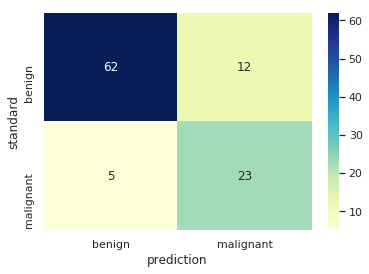

In [15]:
plot_confusion_matrix(validation, results)

In [16]:
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=validation.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.833,62,23,5,12,0.838,0.821,0.925,0.657,0.179,0.162,0.075,0.830,0.830
malignant,0.833,23,62,12,5,0.821,0.838,0.657,0.925,0.162,0.179,0.343,0.830,0.830


## ROC Curve standalone

No handles with labels found to put in legend.


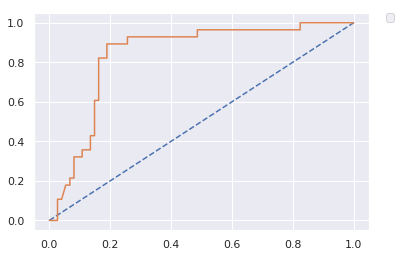

In [17]:
plot_roc_curve(labels, results)

In [18]:
print("ROC AUC:", roc_auc_score(labels, probabilities))

ROC AUC: 0.8383204633204634


## Precision Recall

In [19]:
print("Average precision:", average_precision_score(labels, probabilities))
print("Precision:", precision_score(labels, predictions), "Recall:", recall_score(labels, predictions))

Average precision: 0.5598201070390206
Precision: 0.6571428571428571 Recall: 0.8214285714285714


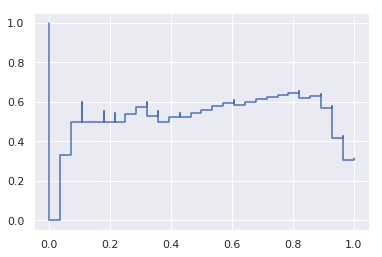

In [20]:
plot_precision_recall(labels, results)

In [21]:
print("PR AUC:", calculate_pr_auc(labels, results))

PR AUC: 0.5396324497392765


## F1 Score

In [22]:
print("F1 score:", f1_score(labels, predictions))

F1 score: 0.73015873015873


## TSNE

In [23]:
malignancy, modality, category = all_features(features=FEATURES)

In [24]:
tsne_dataset = train

In [25]:
tsne_labels = [category.get(accession_from_filename(f), "unknown") for f in tsne_dataset.filenames]

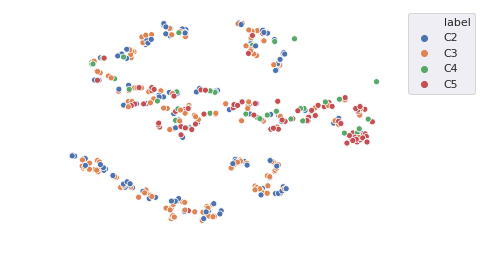

In [26]:
plot_tsne(model, "dense_5", tsne_dataset, tsne_labels, perplexity=5)

## Experts

error with benign/free-27244981-liver.jpeg: '27244981-liver.jpeg'


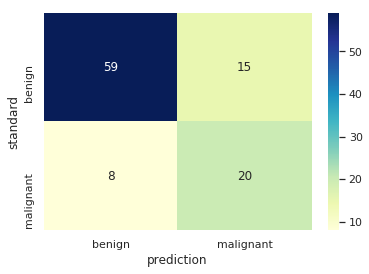

In [27]:
expert_1 = plot_expert_confusion("evaluations/radiology-9809.json", validation)

In [28]:
pandas.DataFrame(expert_1, index=validation.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.775,59,20,8,15,0.797,0.714,0.881,0.571,0.286,0.203,0.119,0.756,0.755
malignant,0.775,20,59,15,8,0.714,0.797,0.571,0.881,0.203,0.286,0.429,0.756,0.755


## ROC with experts

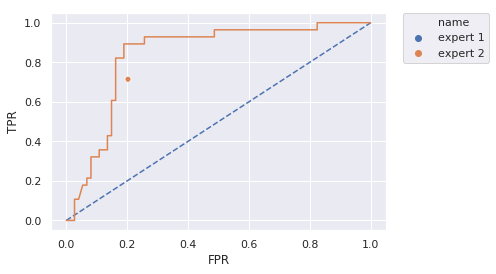

In [29]:
plot_roc_curve(labels, results, experts=[{ **expert_1, "name":"expert 1" }, { **expert_1, "name":"expert 2" }])

## Grad Cam

In [30]:
inv_indices = {v: k for k, v in validation.class_indices.items()}
for k, v in SELECTIONS.items(): 
    display(HTML("<h5>diagnosis: {} | prediction: {}</h5>".format(inv_indices[k[0]], inv_indices[k[1]])))
    plot_multiple_grad_cam(
        [os.path.join(VALIDATION, image) for image in v], 
        model, 
        "dense_6", 
    )
    print(get_expert_results("evaluations/radiology-9809.json", v, expert_key="malignantBenign"))

<Figure size 432x288 with 0 Axes>

[]


<Figure size 432x288 with 0 Axes>

[]


<Figure size 432x288 with 0 Axes>

[]


<Figure size 432x288 with 0 Axes>

[]


In [31]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')